# Multi-component flow with Jutul

## Load the MultiComponentFlash module and define a three-component mixture
The equation-of-state defaults to Peng-Robinson. Components are defined by their molar mass, their critical pressure and temperature, their critical volume and their acentric factors.

In [7]:
using MultiComponentFlash
co2 = MolecularProperty(0.0440, 7.38e6, 304.1, 9.412e-5, 0.224)
c1 = MolecularProperty(0.0160, 4.60e6, 190.6, 9.863e-5, 0.011)
c10 = MolecularProperty(0.0142, 2.10e6, 617.7, 6.098e-4, 0.488)

mixture = MultiComponentMixture([co2, c1, c10], names = ["CO2", "C1", "C10"])
eos = GenericCubicEOS(mixture);

## Define a 1D Jutul mesh

In [8]:
using Jutul, JutulDarcy
nx = 100
ny = nz = 1
bar = 1e5
dims = (nx, ny, nz)
g = CartesianMesh(dims, (2000.0, 1500.0, 50.0))
nc = number_of_cells(g)
K = repeat([1e-13], nc)
## Set up a vertical well in the first corner, perforated in all layers
prod = setup_vertical_well(g, K, nx, 1, name = :Producer);
## Set up an injector in the upper left corner
inj = setup_vertical_well(g, K, 1, 1, name = :Injector);

## Create a compositional system and set up the reservoir model

In [9]:
rhoLS, rhoVS = 1000.0, 100.0
rhoS = [rhoLS, rhoVS]
L, V = LiquidPhase(), VaporPhase()
# Define system and realize on grid
sys = MultiPhaseCompositionalSystemLV(eos, (L, V))
model, parameters = setup_reservoir_model(g, sys, wells = [inj, prod], reference_densities = rhoS, block_backend = true);
state0 = setup_reservoir_state(model, Pressure = 150*bar, OverallMoleFractions = [0.5, 0.3, 0.2])

Dict{Any, Any} with 4 entries:
  :Producer  => Dict{Symbol, Any}(:OverallMoleFractions=>[0.5 0.5; 0.3 0.3; 0.2…
  :Injector  => Dict{Symbol, Any}(:OverallMoleFractions=>[0.5 0.5; 0.3 0.3; 0.2…
  :Reservoir => Dict{Symbol, Any}(:OverallMoleFractions=>[0.5 0.5 … 0.5 0.5; 0.…
  :Facility  => Dict{Symbol, Any}(:TotalSurfaceMassRate=>[0.0, 0.0], :WellGroup…

### Define injection schedule

In [10]:
day = 365*3600.0
dt = repeat([5.0]*day, 100)
reservoir = reservoir_model(model);
pv = pore_volume(model)
inj_rate = sum(pv)/sum(dt)
rate_target = TotalRateTarget(inj_rate)
ϵ = 1e-3
I_ctrl = InjectorControl(rate_target, [1.0 - 2*ϵ, ϵ, ϵ], density = rhoVS)
bhp_target = BottomHolePressureTarget(50*bar)
P_ctrl = ProducerControl(bhp_target)

controls = Dict()
controls[:Injector] = I_ctrl
controls[:Producer] = P_ctrl
forces = setup_reservoir_forces(model, control = controls);

### Run the simulation

In [11]:
sim, config = setup_reservoir_simulator(model, state0, parameters, info_level = -1)
states, reports = simulate!(sim, dt, forces = forces, config = config);

### Plot the mole fractions at the end of the simulation

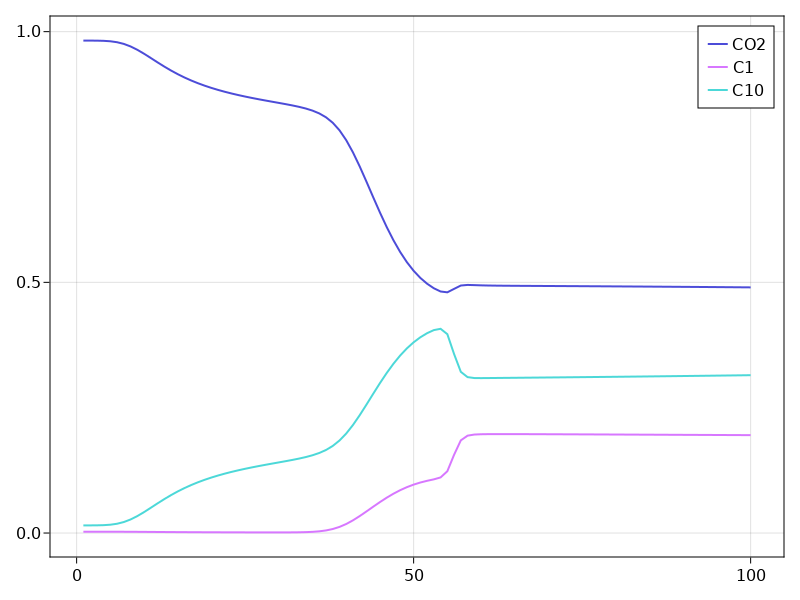

In [12]:
using CairoMakie
fig, ax, sp = series(1:nc, states[end][:Reservoir][:OverallMoleFractions], labels = mixture.component_names)
axislegend(ax)
fig